<a href="https://colab.research.google.com/github/KHamdyFAN/KHamdyFAN/blob/ML/ECG5000_Autoencoder(Anomaly_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

In [2]:
# Load the .arff data
def load_arff_data(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
    return df

# Load your training and test datasets
train_df = load_arff_data('ECG5000_TRAIN.arff')
test_df = load_arff_data('ECG5000_TEST.arff')

print(train_df.columns)
print('\n\n',train_df.describe)
print('\n\n',train_df.isna().sum())
print('\n\n',test_df.columns)
print('\n\n',test_df.describe)
print('\n\n',test_df.isna().sum())

Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)


 <bound method NDFrame.describe of          att1      att2      att3      att4      att5      att6      att7  \
0   -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1   -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2   -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3    0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4    0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.478577 -1.779959 -2.398159 -3.170112 -3.559732 -3.573956 -2.989770   
496 -1.325210 -2.480992 -2.965356 -3.342392 -3.176351 -2.891528 -2.369679   
497 -0.021964 -

# Class Distribution

Class distribution in training set:
target
b'1'    292
b'2'    177
b'4'     19
b'3'     10
b'5'      2
Name: count, dtype: int64

Class distribution in test set:
target
b'1'    2627
b'2'    1590
b'4'     175
b'3'      86
b'5'      22
Name: count, dtype: int64


<ipython-input-3-52419079b109>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train_df, palette='Set2')
<ipython-input-3-52419079b109>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=test_df, palette='Set2')


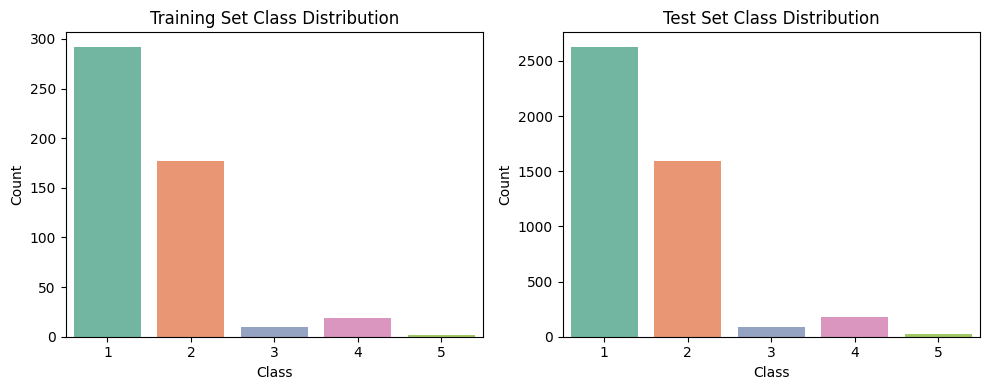

In [3]:
# Check unique classes and their counts in train and test
print("Class distribution in training set:")
print(train_df['target'].value_counts())

print("\nClass distribution in test set:")
print(test_df['target'].value_counts())

# Plot class distribution
plt.figure(figsize=(10, 4))

# Training set
plt.subplot(1, 2, 1)
sns.countplot(x='target', data=train_df, palette='Set2')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Test set
plt.subplot(1, 2, 2)
sns.countplot(x='target', data=test_df, palette='Set2')
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Test 1

In [4]:
# Decode the target labels from bytes to regular strings (e.g., b'1' → '1')
test_df['target'] = test_df['target'].apply(lambda x: x.decode('utf-8'))

# Extract the test features by dropping the target column
X_test_raw = test_df.drop(columns=['target']).values

# Create binary labels: 0 for normal (class '1'), 1 for all other classes (anomalies)
y_test = test_df['target'].apply(lambda x: 0 if x == '1' else 1).values

# Print the distribution of normal vs. anomalous samples in the test set
print("Final y_test distribution:", np.unique(y_test, return_counts=True))

Final y_test distribution: (array([0, 1]), array([2627, 1873]))


# Autoencoder V1 (Base)

In [5]:
# Extract training features by removing the target column
X_train_raw = train_df.drop(columns=['target']).values

# Standardize the features: zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Split a small portion of the training set for validation (10%)
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

def build_simple_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    bottleneck = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(bottleneck)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(input_dim, activation='linear')(x)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

autoencoder = build_simple_autoencoder(X_train.shape[1])

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.9940 - val_loss: 1.0284
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7516 - val_loss: 0.7580
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6087 - val_loss: 0.5939
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4574 - val_loss: 0.5169
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3445 - val_loss: 0.4823
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3702 - val_loss: 0.4607
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3191 - val_loss: 0.4467
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2963 - val_loss: 0.4233
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2715 - val_loss: 0.4006
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2482 - val_loss: 0.3751
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2287 - val_loss: 0.3600
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste

# Loss Plot

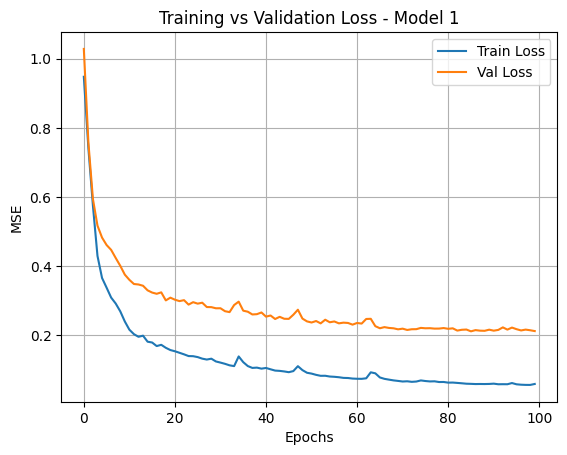

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss - Model 1')
plt.xlabel('Epochs'); plt.ylabel('MSE'); plt.legend(); plt.grid(True)
plt.show()

# Testing Evaluation

In [8]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=1)
X_train_reconstructed = autoencoder.predict(X_train)
train_errors = np.mean(np.square(X_train - X_train_reconstructed), axis=1)
threshold = np.percentile(train_errors, 90)
print(f"Anomaly Threshold (90th percentile): {threshold:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Anomaly Threshold (90th percentile): 0.0898


In [9]:
y_pred = (reconstruction_errors > threshold).astype(int)
print("\n--- Evaluation Report (Model 1) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, reconstruction_errors):.4f}")
print(classification_report(y_test, y_pred))


--- Evaluation Report (Model 1) ---
Accuracy: 0.5189
Precision: 0.3748
Recall: 0.2333
F1: 0.2876
ROC-AUC: 0.4230
              precision    recall  f1-score   support

           0       0.57      0.72      0.64      2627
           1       0.37      0.23      0.29      1873

    accuracy                           0.52      4500
   macro avg       0.47      0.48      0.46      4500
weighted avg       0.49      0.52      0.49      4500



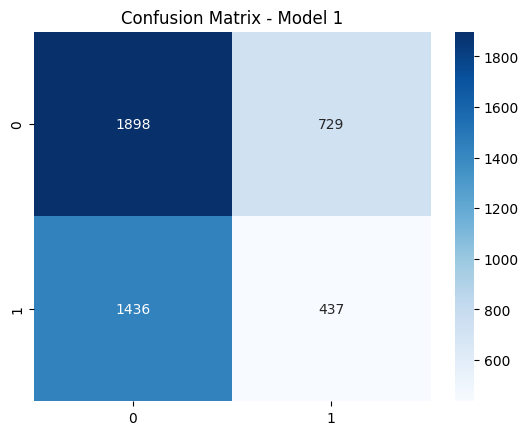

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix - Model 1")
plt.show()

# Autoencoder V2 (Normal Only)

In [11]:
train_df['target'] = train_df['target'].apply(lambda x: x.decode('utf-8'))
train_normal_df = train_df[train_df['target'] == '1']
X_train_raw = train_normal_df.drop(columns=['target']).values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

autoencoder = build_simple_autoencoder(X_train.shape[1])

In [12]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.9442 - val_loss: 0.8206
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9301 - val_loss: 0.7340
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8918 - val_loss: 0.6326
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7002 - val_loss: 0.5255
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5663 - val_loss: 0.4454
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4245 - val_loss: 0.3768
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3717 - val_loss: 0.3225
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3344 - val_loss: 0.2999
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3136 - val_loss: 0.2960
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3160 - val_loss: 0.2706
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2695 - val_loss: 0.2650
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2687 - val_lo

# Test Evaluation (V2)

In [13]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=1)
X_train_reconstructed = autoencoder.predict(X_train)
train_errors = np.mean(np.square(X_train - X_train_reconstructed), axis=1)
threshold = np.percentile(train_errors, 90)
print(f"Anomaly Threshold (90th percentile): {threshold:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Anomaly Threshold (90th percentile): 0.1178


In [14]:
y_pred = (reconstruction_errors > threshold).astype(int)
print("\n--- Evaluation Report (Model 2 - Normal Only) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, reconstruction_errors):.4f}")
print(classification_report(y_test, y_pred))


--- Evaluation Report (Model 2 - Normal Only) ---
Accuracy: 0.7969
Precision: 0.6723
Recall: 0.9989
F1: 0.8037
ROC-AUC: 0.9857
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      2627
           1       0.67      1.00      0.80      1873

    accuracy                           0.80      4500
   macro avg       0.84      0.83      0.80      4500
weighted avg       0.86      0.80      0.80      4500



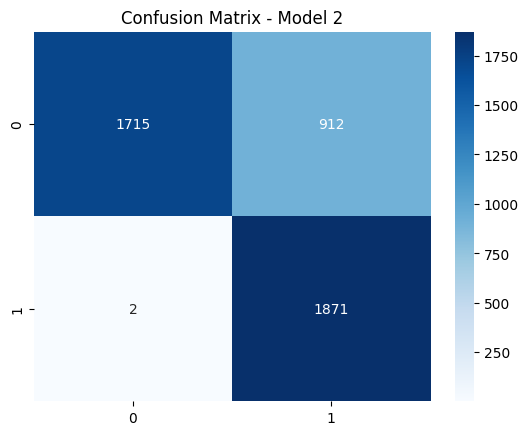

In [15]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix - Model 2")
plt.show()

# Autoencoder V3 (Normal + L2 + Dropout)

In [16]:
def build_regularized_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    bottleneck = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(bottleneck)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(input_dim, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

autoencoder = build_regularized_autoencoder(X_train.shape[1])

In [17]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.1496 - val_loss: 1.0417
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1396 - val_loss: 1.0055
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9782 - val_loss: 0.9322
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9161 - val_loss: 0.8641
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8680 - val_loss: 0.8090
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7799 - val_loss: 0.7012
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6783 - val_loss: 0.6052
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5900 - val_loss: 0.5086
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6086 - val_loss: 0.4670
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4884 - val_loss: 0.4369
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5079 - val_loss: 0.4186
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4714 - val_lo

In [18]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=1)
X_train_reconstructed = autoencoder.predict(X_train)
train_errors = np.mean(np.square(X_train - X_train_reconstructed), axis=1)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [21]:
thresholds = [85, 90, 95]
for t in thresholds:
    threshold = np.percentile(train_errors, t)
    y_pred = (reconstruction_errors > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📊 Threshold: {t}th percentile")
    print(f"Threshold value: {threshold:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


📊 Threshold: 85th percentile
Threshold value: 0.3146
Accuracy : 0.8822
Precision: 0.7799 | Recall: 0.9989 | F1: 0.8759

📊 Threshold: 90th percentile
Threshold value: 0.3730
Accuracy : 0.9136
Precision: 0.8289 | Recall: 0.9984 | F1: 0.9058

📊 Threshold: 95th percentile
Threshold value: 0.5298
Accuracy : 0.9522
Precision: 0.8993 | Recall: 0.9968 | F1: 0.9456


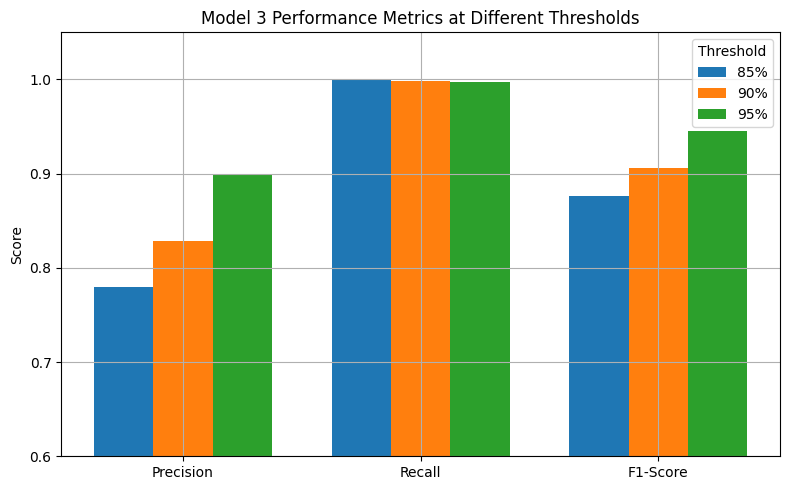

In [22]:
# Scores per threshold
thresholds = ['85%', '90%', '95%']
precisions = [0.7799, 0.8289, 0.8993]
recalls = [0.9989, 0.9984, 0.9968]
f1_scores = [0.8759, 0.9058, 0.9456]

# Reorganize for metric-based grouping
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precisions, recalls, f1_scores]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, [s[0] for s in scores], width, label='85%')
plt.bar(x,         [s[1] for s in scores], width, label='90%')
plt.bar(x + width, [s[2] for s in scores], width, label='95%')

plt.xticks(x, metrics)
plt.ylim(0.6, 1.05)
plt.ylabel('Score')
plt.title('Model 3 Performance Metrics at Different Thresholds')
plt.legend(title='Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary:


Project Summary:


This project applies unsupervised deep learning techniques to detect anomalies in ECG signals
from the ECG5000 dataset. The approach is based on autoencoders, which are trained to learn
and reconstruct patterns of normal heartbeats. The reconstruction error is used to identify
anomalous signals that deviate from this learned normal pattern.


------


**Models Developed:**
1. Model 1 (Baseline): Trained on both normal and abnormal data.
   - Weak anomaly separation due to learning to reconstruct everything.

2. Model 2 (Clean): Trained only on class '1' (normal data).
   - Significantly improved performance by focusing on normal patterns only.

3. Model 3 (Optimized): Trained on normal data with Dropout and L2 regularization.
   - Achieved the best results, with high precision, recall, and F1-score.

-------------

**Evaluation Metrics:**

- Reconstruction error used to identify anomalies.
- Thresholds (85%, 90%, 95%) tested to control sensitivity.
- Metrics: Precision, Recall, F1-Score, Accuracy, ROC-AUC.

------------------
**Why Normal-Only Training Works:**

By training exclusively on normal data, the model becomes highly sensitive to anything
unfamiliar (anomalies), resulting in higher reconstruction error. This improves anomaly
detection accuracy and ensures better separation between normal and abnormal signals.

------------
**Conclusion:**

Autoencoders are highly effective for anomaly detection when trained only on clean data.
Proper threshold tuning and regularization significantly improve detection performance.
